# Univariate, Multistep LSTM Implementation

An implementation of a univariate, multistep LSTM for the Close price of NYSE: ECL operating on daily resolution. The model uses 30 timesteps back to predict 30 timesteps forward. Data pre-processing has been completed in another notebook.

## Table of Contents
* Libraries
* Load Data
  * Split Data
* Vanilla LSTM
* LSTM Optimization
* LSTM Walk Forward Validation
* Validation Results
  * Overall
  * First Model
  * Last Model
* Conclusions

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import tqdm
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16661610977987491896
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11736408643279005200
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6516530181572404801
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15848577434
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18082197543274280920
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## Load the data
#### Daily Resolution Data

In [5]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('ECL_Clean_Day.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    print (df_day.shape)
    
#print (df_day.head(3))

(5031, 16)


#### Split the data

We'll use the past 10 years of data

In [6]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

Slice out 'Close' price from dataset

In [7]:
base_train = day_train['Close'] 
base_test = day_test['Close']

Plot the Test and Train split

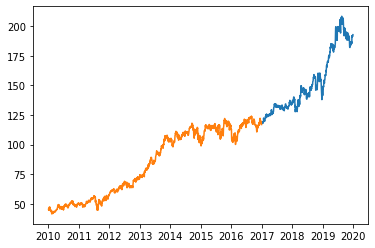

In [8]:
plt.plot(base_test)
plt.plot(base_train)
plt.show()

## Vanilla LSTM

Initialize a vanilla LSTM with a single LSTM layer and a single dense layer to provide the output.

In [9]:
# Multistep Data Preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 30, 30

# split into samples
X_train, y_train = split_sequence(base_train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(base_test.values, n_steps_in, n_steps_out)

# summarize the data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1703, 30) (1703, 30) (695, 30) (695, 30)


In [10]:
#Load required Keras modules
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
#print (X_train.shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
#print (X_test.shape)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu',  input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='Adam', loss='mse')
model.summary()

# fit model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, 
                    verbose=1,
                    shuffle=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
Total params: 11,930
Trainable params: 11,930
Non-trainable params: 0
_________________________________________________________________

Train on 1703 samples, validate on 695 samples
Epoch 1/20
1703/1703 [==============================] - 2s 1ms/step - loss: 6753.7578 - val_loss: 15700.8646
Epoch 2/20
1703/1703 [==============================] - 1s 851us/step - loss: 3855.0170 - val_loss: 8603.5194
Epoch 3/20
1703/1703 [==============================] - 1s 841us/step - loss: 900.1534 - val_loss: 980.2821
Epoch 4/20
1703/1703 [==============================] - 1s 839us/step - loss: 65.0359 - val_loss: 419.0368
Epoch 5/20
1703/1703 [========

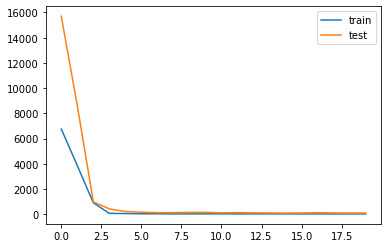

In [11]:
#Plot the Training and Validation Loss

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Training Results
* Model appears to train without overfit
* This is obviously a very simple model and no further optimization will be done on it.

### Demonstrate Prediction

In [12]:
# Use X_test[0] as test
x_input = X_test[0]
print ('Shape of X_test[0]:,',X_test[0].shape)

# Reshape X_test[0]
x_input = x_input.reshape((1, n_steps_in, n_features))
print ('Shape of x_input:', x_input.shape)

# Make a prediction
yhat = model.predict(x_input, verbose=0)
print ('Shape of yhat:', yhat.shape)

Shape of X_test[0]:, (30, 1)
Shape of x_input: (1, 30, 1)
Shape of yhat: (1, 30)


Plot the input, output and prediction

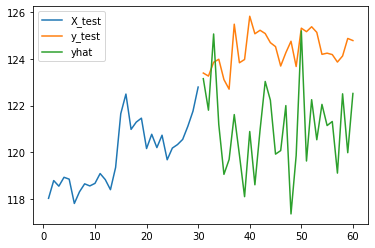

In [13]:
plt.plot(range(1,31), X_test[0], label = 'X_test')
plt.plot(range(31, 61), y_test[0], label = 'y_test')
plt.plot(range(31, 61), yhat[0], label = 'yhat')
plt.legend()
plt.show()

In [14]:
mae = metrics.mean_absolute_error(y_test[0], yhat[0])
rmse = metrics.mean_squared_error(y_test[0], yhat[0])
print ('Mean Absolute Error:', mae)
print ('Mean Squared Error:', rmse)

Mean Absolute Error: 3.4429441324869794
Mean Squared Error: 14.765899332596076


* Results suggest even this very simple LSTM has the potential to outperform the baseline model. This is only a single prediction step so I can't read into this very far.

## LSTM Architecture Optimization
* In order to arrive at an optimized architecture for the LSTM, I have used the ```talos``` library. This allows an extensive grid search to be setup and then automated. This has been conduced on a Google Cloud VM. The Jupyter Notebook used can be found accompanying the project submission.
<br>
* The best architecture from this grid search is summarized below.

In [15]:
#Define the LSTM Model from the Talos grid search in a function to be called in the loop below

def LSTM_model():
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(400))
    model.add(Dense(400))
    model.add(Dense(400))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='Adam', loss='mse')
    return model

#### Optimized Architecture

In [16]:
model = LSTM_model()
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               40400     
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 30)               

## Walk-Forward Validation w/ re-fit

Validate the model by waking it forward on the training set. Testing set size is kept stationary. Step size is 30 which is intended to mimic a realistic situation of re-training once per month.

In [18]:
#Inputs for Walk-Forward with re-fit at each step
X = day_data['Close'] 
n_train = len(base_train)
n_records = len(base_train)+len(base_test)
step = 30
n_steps_in = 30
n_steps_out = 30
n_features = 1

pred_dict = dict()
errors = list()
count = 0

#Main Loop
for i in tqdm.tqdm_notebook(np.arange(n_train, n_records, step)):
    #split data
    train, test = X[0:i], X[n_train:]
    
    #rearrange to supervised
    X_train, y_train = split_sequence(train.values, n_steps_in, n_steps_out)
    X_test, y_test = split_sequence(test.values, n_steps_in, n_steps_out)
    
    #reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    
    #create model
    model = LSTM_model()
    es = EarlyStopping(monitor='val_loss', 
                       mode='auto',
                       patience=50,
                       restore_best_weights=True)
    
    #fit the model
    model_fit = model.fit(X_train, y_train, 
                          validation_data=(X_test, y_test), 
                          epochs=100, 
                          callbacks=[es],
                          batch_size=120,
                          verbose=1, 
                          shuffle=False)
    
    #create the prediction counter for X_test loop
    time_count = 0
    
    #reset list for all the predictions
    predictions = list()
    
    #reset dict to catch all the output dfs (res)
    fore_dict = dict()
    
    #predict loop for each sample in X_test
    for t in np.arange(0, len(X_test), 1):
        x_input = X_test[t]
        x_input = x_input.reshape((1, n_steps_in, n_features))
        yhat = model.predict(x_input, verbose=0)
        predictions.append(yhat[0])
        
        #create output df and save into dict
        res = pd.DataFrame(list(range(1,n_steps_out+1)), columns=['Day'])
        res['Pred'] = yhat[0]
        fore_dict[time_count] = res
        time_count += 1
    
    pred_dict[count] = fore_dict
    
    #calculate error for all predictions (X_test)
    mae = metrics.mean_absolute_error(y_test, predictions)
    rmse = metrics.mean_squared_error(y_test, predictions)
    err = [count+1, mae, rmse]
    errors.append(err)
    
    #print update
    print('Step:',count+1)
    print('MAE:',mae)
    print('RMSE:',rmse)
    print('\n')
    
    #increase counter
    count += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


Train on 1703 samples, validate on 695 samples
Epoch 1/100
1703/1703 [==============================] - 3s 2ms/step - loss: 11864.4289 - val_loss: 30928.2681
Epoch 2/100
1703/1703 [==============================] - 1s 619us/step - loss: 8572.9963 - val_loss: 10961.9157
Epoch 3/100
1703/1703 [==============================] - 1s 631us/step - loss: 3842.5273 - val_loss: 8061.1430
Epoch 4/100
1703/1703 [==============================] - 1s 640us/step - loss: 9055.8517 - val_loss: 67278.1220
Epoch 5/100
1703/1703 [==============================] - 1s 661us/step - loss: 29916.2344 - val_loss: 21497.2824
Epoch 6/100
1703/1703 [==============================] - 1s 652us/step - loss: 13431.7264 - val_loss: 56810.3358
Epoch 7/100
1703/1703 [==============================] - 1s 640us/step - loss: 14255.0352 - val_loss: 28022.1857
Epoch 8/100
1703/1703 [==============================] - 1s 641us/step - loss: 11583.6329 - val_loss: 527030.0638
Epoch 9/100
1703/1703 [==============================]

Epoch 75/100
1703/1703 [==============================] - 1s 617us/step - loss: 23.9290 - val_loss: 714.1339
Epoch 76/100
1703/1703 [==============================] - 1s 637us/step - loss: 24.7370 - val_loss: 784.6152
Epoch 77/100
1703/1703 [==============================] - 1s 641us/step - loss: 24.3061 - val_loss: 755.8139
Epoch 78/100
1703/1703 [==============================] - 1s 634us/step - loss: 24.5842 - val_loss: 480.3731
Epoch 79/100
1703/1703 [==============================] - 1s 636us/step - loss: 23.8868 - val_loss: 505.5706
Epoch 80/100
1703/1703 [==============================] - 1s 655us/step - loss: 24.3010 - val_loss: 606.9722
Epoch 81/100
1703/1703 [==============================] - 1s 648us/step - loss: 23.4162 - val_loss: 639.0173
Epoch 82/100
1703/1703 [==============================] - 1s 661us/step - loss: 23.4982 - val_loss: 545.4304
Epoch 83/100
1703/1703 [==============================] - 1s 638us/step - loss: 23.1636 - val_loss: 557.6347
Epoch 84/100
1703/1

Epoch 22/100
1763/1763 [==============================] - 1s 580us/step - loss: 165.5318 - val_loss: 600.8482
Epoch 23/100
1763/1763 [==============================] - 1s 573us/step - loss: 179.7754 - val_loss: 705.5001
Epoch 24/100
1763/1763 [==============================] - 1s 591us/step - loss: 151.6140 - val_loss: 842.1211
Epoch 25/100
1763/1763 [==============================] - 1s 581us/step - loss: 209.3340 - val_loss: 786.5499
Epoch 26/100
1763/1763 [==============================] - 1s 591us/step - loss: 193.1963 - val_loss: 869.2634
Epoch 27/100
1763/1763 [==============================] - 1s 620us/step - loss: 247.7611 - val_loss: 1226.8235
Epoch 28/100
1763/1763 [==============================] - 1s 608us/step - loss: 176.6858 - val_loss: 1511.1062
Epoch 29/100
1763/1763 [==============================] - 1s 590us/step - loss: 95.7182 - val_loss: 668.0816
Epoch 30/100
1763/1763 [==============================] - 1s 590us/step - loss: 111.6766 - val_loss: 343.9923
Epoch 31/

1763/1763 [==============================] - 1s 595us/step - loss: 20.9920 - val_loss: 66.5635
Epoch 98/100
1763/1763 [==============================] - 1s 590us/step - loss: 20.9950 - val_loss: 66.7123
Epoch 99/100
1763/1763 [==============================] - 1s 581us/step - loss: 21.0031 - val_loss: 66.8780
Epoch 100/100
1763/1763 [==============================] - 1s 587us/step - loss: 21.0110 - val_loss: 67.0565
Step: 3
MAE: 6.181466879542655
RMSE: 67.05645783879248


Train on 1793 samples, validate on 695 samples
Epoch 1/100
1793/1793 [==============================] - 3s 2ms/step - loss: 7953.4517 - val_loss: 8400.3211
Epoch 2/100
1793/1793 [==============================] - 1s 569us/step - loss: 2506.4383 - val_loss: 4569.4149
Epoch 3/100
1793/1793 [==============================] - 1s 570us/step - loss: 2275.8651 - val_loss: 8984.5814
Epoch 4/100
1793/1793 [==============================] - 1s 581us/step - loss: 2114.7105 - val_loss: 6346.8183
Epoch 5/100
1793/1793 [===========

1823/1823 [==============================] - 1s 605us/step - loss: 129.0656 - val_loss: 366.3973
Epoch 44/100
1823/1823 [==============================] - 1s 575us/step - loss: 132.4062 - val_loss: 488.6632
Epoch 45/100
1823/1823 [==============================] - 1s 578us/step - loss: 132.0288 - val_loss: 489.0271
Epoch 46/100
1823/1823 [==============================] - 1s 582us/step - loss: 127.9436 - val_loss: 396.1295
Epoch 47/100
1823/1823 [==============================] - 1s 596us/step - loss: 126.6699 - val_loss: 469.9084
Epoch 48/100
1823/1823 [==============================] - 1s 604us/step - loss: 127.0586 - val_loss: 467.9694
Epoch 49/100
1823/1823 [==============================] - 1s 588us/step - loss: 124.3438 - val_loss: 383.4420
Epoch 50/100
1823/1823 [==============================] - 1s 592us/step - loss: 127.0003 - val_loss: 451.2989
Epoch 51/100
1823/1823 [==============================] - 1s 592us/step - loss: 129.3908 - val_loss: 4660.2033
Epoch 52/100
1823/1823

Epoch 16/100
1853/1853 [==============================] - 1s 620us/step - loss: 4911537.9421 - val_loss: 5366767.9353
Epoch 17/100
1853/1853 [==============================] - 1s 599us/step - loss: 2384178.9325 - val_loss: 3559593.6619
Epoch 18/100
1853/1853 [==============================] - 1s 595us/step - loss: 678340.5536 - val_loss: 698300.5549
Epoch 19/100
1853/1853 [==============================] - 1s 612us/step - loss: 162102.0218 - val_loss: 285772.7313
Epoch 20/100
1853/1853 [==============================] - 1s 638us/step - loss: 26052.0648 - val_loss: 19367.2109
Epoch 21/100
1853/1853 [==============================] - 1s 603us/step - loss: 10859.2612 - val_loss: 11684.9014
Epoch 22/100
1853/1853 [==============================] - 1s 612us/step - loss: 4449.2516 - val_loss: 5535.5267
Epoch 23/100
1853/1853 [==============================] - 1s 601us/step - loss: 2467.7577 - val_loss: 3868.7224
Epoch 24/100
1853/1853 [==============================] - 1s 592us/step - loss: 

1883/1883 [==============================] - 1s 589us/step - loss: 24.7147 - val_loss: 555.9422
Epoch 71/100
1883/1883 [==============================] - 1s 597us/step - loss: 23.6881 - val_loss: 567.9370
Epoch 72/100
1883/1883 [==============================] - 1s 590us/step - loss: 22.5302 - val_loss: 577.2618
Epoch 73/100
1883/1883 [==============================] - 1s 584us/step - loss: 23.3306 - val_loss: 565.9255
Epoch 74/100
1883/1883 [==============================] - 1s 587us/step - loss: 28.5094 - val_loss: 553.9920
Epoch 75/100
1883/1883 [==============================] - 1s 584us/step - loss: 41.3902 - val_loss: 572.8892
Epoch 76/100
1883/1883 [==============================] - 1s 612us/step - loss: 69.6872 - val_loss: 669.7529
Epoch 77/100
1883/1883 [==============================] - 1s 613us/step - loss: 110.2213 - val_loss: 778.6700
Epoch 78/100
1883/1883 [==============================] - 1s 623us/step - loss: 124.5973 - val_loss: 898.7139
Epoch 79/100
1883/1883 [======

1913/1913 [==============================] - 1s 568us/step - loss: 35.2844 - val_loss: 79.9113
Epoch 65/100
1913/1913 [==============================] - 1s 570us/step - loss: 28.1822 - val_loss: 77.9121
Epoch 66/100
1913/1913 [==============================] - 1s 552us/step - loss: 21.8896 - val_loss: 66.2243
Epoch 67/100
1913/1913 [==============================] - 1s 568us/step - loss: 19.1510 - val_loss: 60.4708
Epoch 68/100
1913/1913 [==============================] - 1s 556us/step - loss: 31.1153 - val_loss: 74.3391
Epoch 69/100
1913/1913 [==============================] - 1s 557us/step - loss: 60.0398 - val_loss: 92.9957
Epoch 70/100
1913/1913 [==============================] - 1s 551us/step - loss: 64.1245 - val_loss: 76.1912
Epoch 71/100
1913/1913 [==============================] - 1s 564us/step - loss: 100.3870 - val_loss: 108.6957
Epoch 72/100
1913/1913 [==============================] - 1s 556us/step - loss: 187.9152 - val_loss: 228.5735
Epoch 73/100
1913/1913 [=============

1973/1973 [==============================] - 1s 599us/step - loss: 1372.7693 - val_loss: 2217.0523
Epoch 19/100
1973/1973 [==============================] - 1s 641us/step - loss: 856.2113 - val_loss: 2212.2922
Epoch 20/100
1973/1973 [==============================] - 1s 585us/step - loss: 1465.0779 - val_loss: 1774.8639
Epoch 21/100
1973/1973 [==============================] - 1s 593us/step - loss: 913.3496 - val_loss: 1518.6162
Epoch 22/100
1973/1973 [==============================] - 1s 594us/step - loss: 814.6997 - val_loss: 926.7291
Epoch 23/100
1973/1973 [==============================] - 1s 598us/step - loss: 488.6432 - val_loss: 2919.9944
Epoch 24/100
1973/1973 [==============================] - 1s 589us/step - loss: 590.0734 - val_loss: 1494.6970
Epoch 25/100
1973/1973 [==============================] - 1s 586us/step - loss: 1149.1935 - val_loss: 1782.2394
Epoch 26/100
1973/1973 [==============================] - 1s 579us/step - loss: 685.6475 - val_loss: 1733.5627
Epoch 27/100

2003/2003 [==============================] - 1s 573us/step - loss: 2025.1243 - val_loss: 1351.8359
Epoch 65/100
2003/2003 [==============================] - 1s 586us/step - loss: 1777.1156 - val_loss: 1363.3478
Epoch 66/100
2003/2003 [==============================] - 1s 582us/step - loss: 1582.3623 - val_loss: 1347.2149
Epoch 67/100
2003/2003 [==============================] - 1s 574us/step - loss: 1432.5811 - val_loss: 1307.9836
Epoch 68/100
2003/2003 [==============================] - 1s 600us/step - loss: 1320.9510 - val_loss: 1254.1518
Epoch 69/100
2003/2003 [==============================] - 1s 606us/step - loss: 1242.2799 - val_loss: 1195.3170
Epoch 70/100
2003/2003 [==============================] - 1s 618us/step - loss: 1191.9983 - val_loss: 1139.1646
Epoch 71/100
2003/2003 [==============================] - 1s 586us/step - loss: 1166.0702 - val_loss: 1091.3678
Epoch 72/100
2003/2003 [==============================] - 1s 584us/step - loss: 1160.7409 - val_loss: 1056.0291
Epoch

Epoch 36/100
2033/2033 [==============================] - 1s 575us/step - loss: 261836.0626 - val_loss: 142537.0374
Epoch 37/100
2033/2033 [==============================] - 1s 573us/step - loss: 14476.2847 - val_loss: 15053.4006
Epoch 38/100
2033/2033 [==============================] - 1s 574us/step - loss: 4628.3040 - val_loss: 13461.8585
Epoch 39/100
2033/2033 [==============================] - 1s 559us/step - loss: 5571.4485 - val_loss: 19632.1419
Epoch 40/100
2033/2033 [==============================] - 1s 574us/step - loss: 6689.0957 - val_loss: 22699.3216
Epoch 41/100
2033/2033 [==============================] - 1s 590us/step - loss: 7081.2900 - val_loss: 23538.9776
Epoch 42/100
2033/2033 [==============================] - 1s 572us/step - loss: 6709.8454 - val_loss: 18373.0974
Epoch 43/100
2033/2033 [==============================] - 1s 603us/step - loss: 5228.8136 - val_loss: 15044.1683
Epoch 44/100
2033/2033 [==============================] - 1s 581us/step - loss: 4372.2072 - 

2093/2093 [==============================] - 1s 577us/step - loss: 68.7641 - val_loss: 127.4131
Epoch 12/100
2093/2093 [==============================] - 1s 582us/step - loss: 70.9509 - val_loss: 166.2452
Epoch 13/100
2093/2093 [==============================] - 1s 579us/step - loss: 94.3709 - val_loss: 238.1835
Epoch 14/100
2093/2093 [==============================] - 1s 580us/step - loss: 130.7506 - val_loss: 234.7843
Epoch 15/100
2093/2093 [==============================] - 1s 599us/step - loss: 134.4631 - val_loss: 161.3720
Epoch 16/100
2093/2093 [==============================] - 1s 574us/step - loss: 151.2393 - val_loss: 137.5054
Epoch 17/100
2093/2093 [==============================] - 1s 577us/step - loss: 174.4711 - val_loss: 130.8612
Epoch 18/100
2093/2093 [==============================] - 1s 563us/step - loss: 167.7938 - val_loss: 120.6347
Epoch 19/100
2093/2093 [==============================] - 1s 599us/step - loss: 158.8023 - val_loss: 117.9435
Epoch 20/100
2093/2093 [==

2123/2123 [==============================] - 1s 591us/step - loss: 71.3781 - val_loss: 184.8668
Epoch 60/100
2123/2123 [==============================] - 1s 580us/step - loss: 80.9328 - val_loss: 153.0410
Epoch 61/100
2123/2123 [==============================] - 1s 580us/step - loss: 94.5754 - val_loss: 454.1962
Epoch 62/100
2123/2123 [==============================] - 1s 593us/step - loss: 117.0456 - val_loss: 460.0167
Epoch 63/100
2123/2123 [==============================] - 1s 587us/step - loss: 108.0018 - val_loss: 264.4015
Epoch 64/100
2123/2123 [==============================] - 1s 596us/step - loss: 171.7997 - val_loss: 860.3483
Epoch 65/100
2123/2123 [==============================] - 1s 569us/step - loss: 351.6689 - val_loss: 368.6655
Epoch 66/100
2123/2123 [==============================] - 1s 582us/step - loss: 283.4341 - val_loss: 270.0258
Epoch 67/100
2123/2123 [==============================] - 1s 588us/step - loss: 272.0315 - val_loss: 290.4743
Epoch 68/100
2123/2123 [==

2183/2183 [==============================] - 1s 605us/step - loss: 6755.2547 - val_loss: 35760.4896
Epoch 6/100
2183/2183 [==============================] - 1s 595us/step - loss: 8221.2670 - val_loss: 12930.6281
Epoch 7/100
2183/2183 [==============================] - 1s 585us/step - loss: 37803.9297 - val_loss: 83738.5278
Epoch 8/100
2183/2183 [==============================] - 1s 583us/step - loss: 17327.7818 - val_loss: 16055.0344
Epoch 9/100
2183/2183 [==============================] - 1s 591us/step - loss: 36667.9040 - val_loss: 34697.3116
Epoch 10/100
2183/2183 [==============================] - 1s 576us/step - loss: 24915.0779 - val_loss: 3769.5054
Epoch 11/100
2183/2183 [==============================] - 1s 601us/step - loss: 2339.8940 - val_loss: 1427.9357
Epoch 12/100
2183/2183 [==============================] - 1s 664us/step - loss: 528.9356 - val_loss: 479.2733
Epoch 13/100
2183/2183 [==============================] - 1s 634us/step - loss: 358.7942 - val_loss: 311.5803
Epoc

Epoch 61/100
2213/2213 [==============================] - 2s 924us/step - loss: 49.4559 - val_loss: 93.6571
Epoch 62/100
2213/2213 [==============================] - 2s 906us/step - loss: 50.2028 - val_loss: 93.7104
Epoch 63/100
2213/2213 [==============================] - 2s 908us/step - loss: 49.3357 - val_loss: 88.9870
Epoch 64/100
2213/2213 [==============================] - 2s 877us/step - loss: 49.5041 - val_loss: 89.0858
Epoch 65/100
2213/2213 [==============================] - 2s 876us/step - loss: 53.9296 - val_loss: 91.3018
Epoch 66/100
2213/2213 [==============================] - 2s 898us/step - loss: 55.6787 - val_loss: 88.6366
Epoch 67/100
2213/2213 [==============================] - 2s 903us/step - loss: 58.2356 - val_loss: 88.6308
Epoch 68/100
2213/2213 [==============================] - 2s 897us/step - loss: 56.6160 - val_loss: 83.8696
Epoch 69/100
2213/2213 [==============================] - 2s 910us/step - loss: 57.5507 - val_loss: 85.9477
Epoch 70/100
2213/2213 [====

Epoch 35/100
2273/2273 [==============================] - 2s 871us/step - loss: 509.2447 - val_loss: 450.8544
Epoch 36/100
2273/2273 [==============================] - 2s 870us/step - loss: 548.5487 - val_loss: 385.2466
Epoch 37/100
2273/2273 [==============================] - 2s 880us/step - loss: 617.4707 - val_loss: 372.1679
Epoch 38/100
2273/2273 [==============================] - 2s 877us/step - loss: 708.3840 - val_loss: 443.4498
Epoch 39/100
2273/2273 [==============================] - 2s 875us/step - loss: 799.3115 - val_loss: 588.3916
Epoch 40/100
2273/2273 [==============================] - 2s 879us/step - loss: 865.8886 - val_loss: 759.1244
Epoch 41/100
2273/2273 [==============================] - 2s 915us/step - loss: 900.9682 - val_loss: 916.8336
Epoch 42/100
2273/2273 [==============================] - 2s 895us/step - loss: 923.4515 - val_loss: 1074.5245
Epoch 43/100
2273/2273 [==============================] - 2s 866us/step - loss: 965.3578 - val_loss: 1290.7398
Epoch 44

Epoch 8/100
2303/2303 [==============================] - 2s 922us/step - loss: 274.9818 - val_loss: 187.5137
Epoch 9/100
2303/2303 [==============================] - 2s 916us/step - loss: 69.8803 - val_loss: 145.7188
Epoch 10/100
2303/2303 [==============================] - 2s 917us/step - loss: 75.8806 - val_loss: 95.3690
Epoch 11/100
2303/2303 [==============================] - 2s 906us/step - loss: 91.0765 - val_loss: 195.9168
Epoch 12/100
2303/2303 [==============================] - 2s 914us/step - loss: 97.0284 - val_loss: 162.4452
Epoch 13/100
2303/2303 [==============================] - 2s 914us/step - loss: 100.9845 - val_loss: 161.4881
Epoch 14/100
2303/2303 [==============================] - 2s 889us/step - loss: 98.7190 - val_loss: 182.7807
Epoch 15/100
2303/2303 [==============================] - 2s 913us/step - loss: 134.3994 - val_loss: 147.9198
Epoch 16/100
2303/2303 [==============================] - 2s 926us/step - loss: 137.4627 - val_loss: 134.2581
Epoch 17/100
2303/

2303/2303 [==============================] - 2s 829us/step - loss: 39.0974 - val_loss: 62.7166
Epoch 84/100
2303/2303 [==============================] - 2s 778us/step - loss: 39.7653 - val_loss: 86.9303
Epoch 85/100
2303/2303 [==============================] - 2s 944us/step - loss: 49.1950 - val_loss: 60.0647
Epoch 86/100
2303/2303 [==============================] - 2s 946us/step - loss: 45.3337 - val_loss: 72.5990
Epoch 87/100
2303/2303 [==============================] - 2s 931us/step - loss: 39.2569 - val_loss: 109.1115
Epoch 88/100
2303/2303 [==============================] - 2s 928us/step - loss: 33.8570 - val_loss: 81.9443
Epoch 89/100
2303/2303 [==============================] - 2s 939us/step - loss: 40.2807 - val_loss: 63.1161
Epoch 90/100
2303/2303 [==============================] - 2s 939us/step - loss: 40.2245 - val_loss: 64.7905
Epoch 91/100
2303/2303 [==============================] - 2s 935us/step - loss: 35.8738 - val_loss: 76.7759
Epoch 92/100
2303/2303 [================

2363/2363 [==============================] - 2s 881us/step - loss: 2593.5696 - val_loss: 3767.1414
Epoch 47/100
2363/2363 [==============================] - 2s 904us/step - loss: 3434.9012 - val_loss: 4200.7487
Epoch 48/100
2363/2363 [==============================] - 2s 907us/step - loss: 4638.9290 - val_loss: 3805.1120
Epoch 49/100
2363/2363 [==============================] - 2s 908us/step - loss: 5505.3221 - val_loss: 3098.0766
Epoch 50/100
2363/2363 [==============================] - 2s 890us/step - loss: 6695.6117 - val_loss: 3678.8486
Epoch 51/100
2363/2363 [==============================] - 2s 897us/step - loss: 7365.8808 - val_loss: 3842.0111
Epoch 52/100
2363/2363 [==============================] - 2s 885us/step - loss: 6294.8446 - val_loss: 6897.5545
Epoch 53/100
2363/2363 [==============================] - 2s 900us/step - loss: 3296.8461 - val_loss: 11831.9230
Epoch 54/100
2363/2363 [==============================] - 2s 899us/step - loss: 6482.8135 - val_loss: 7775.5789
Epoc

Epoch 19/100
2393/2393 [==============================] - 2s 881us/step - loss: 4227.7029 - val_loss: 1962.2758
Epoch 20/100
2393/2393 [==============================] - 2s 887us/step - loss: 1166.8189 - val_loss: 2244.2269
Epoch 21/100
2393/2393 [==============================] - 2s 867us/step - loss: 1188.7612 - val_loss: 522.3250
Epoch 22/100
2393/2393 [==============================] - 2s 870us/step - loss: 536.1459 - val_loss: 1274.6006
Epoch 23/100
2393/2393 [==============================] - 2s 877us/step - loss: 357.5209 - val_loss: 557.3988
Epoch 24/100
2393/2393 [==============================] - 2s 890us/step - loss: 447.3049 - val_loss: 723.1701
Epoch 25/100
2393/2393 [==============================] - 2s 879us/step - loss: 314.0504 - val_loss: 269.5572
Epoch 26/100
2393/2393 [==============================] - 2s 883us/step - loss: 248.9881 - val_loss: 205.3842
Epoch 27/100
2393/2393 [==============================] - 2s 889us/step - loss: 148.8177 - val_loss: 136.9451
Epoc

2423/2423 [==============================] - 2s 895us/step - loss: 78.4327 - val_loss: 127.2579
Epoch 73/100
2423/2423 [==============================] - 2s 902us/step - loss: 67.0653 - val_loss: 117.6285
Epoch 74/100
2423/2423 [==============================] - 2s 913us/step - loss: 64.5393 - val_loss: 163.6233
Epoch 75/100
2423/2423 [==============================] - 2s 923us/step - loss: 74.1204 - val_loss: 126.5426
Epoch 76/100
2423/2423 [==============================] - 2s 897us/step - loss: 81.5766 - val_loss: 127.2102
Epoch 77/100
2423/2423 [==============================] - 2s 938us/step - loss: 111.5332 - val_loss: 140.4032
Epoch 78/100
2423/2423 [==============================] - 2s 911us/step - loss: 133.6186 - val_loss: 141.5926
Epoch 79/100
2423/2423 [==============================] - 2s 911us/step - loss: 205.8681 - val_loss: 231.8269
Epoch 80/100
2423/2423 [==============================] - 2s 912us/step - loss: 206.7200 - val_loss: 205.4114
Epoch 81/100
2423/2423 [====

## Validation Results

In this section we'll look at the overall performance of the model over the entire walk-forward and then dive into a couple of specific iterations looking more closely.

### Overall Model Error

When we calculate the errors here, we're looking at each prediction at each timestep (695 samples x 30 timesteps prediction = ~20k predictions).

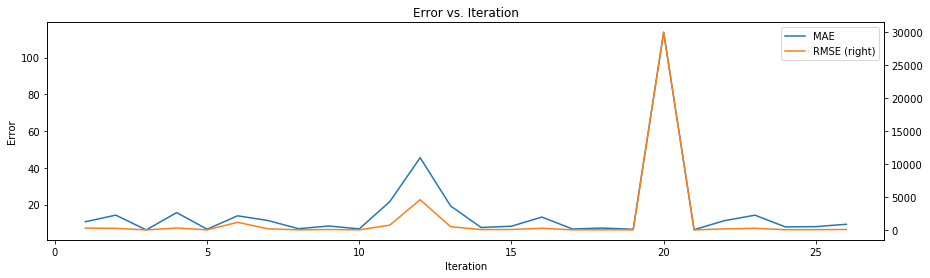

In [31]:
error_df = pd.DataFrame.from_records(errors, columns=['Iteration', 'MAE', 'RMSE'])
ax = error_df.plot(x='Iteration', y=['MAE', 'RMSE'], secondary_y=['RMSE'],
             figsize=(15,4),
             title='Error vs. Iteration')
ax.set(ylabel='Error')
plt.show()

In [32]:
error_df.describe()

,Iteration,MAE,RMSE
count,26.000000,26.000000,26.000000
mean,13.500000,15.630885,1559.936251
std,7.648529,21.567383,5862.413154
min,1.000000,6.181467,65.354670
25%,7.250000,6.937323,82.322137
50%,13.500000,8.788565,132.832072
75%,19.750000,14.118362,330.883990
max,26.000000,113.766091,29963.144739


Now, we'll zoom into two specific iterations (first and last) and explore their skill more deeply.

### First Model

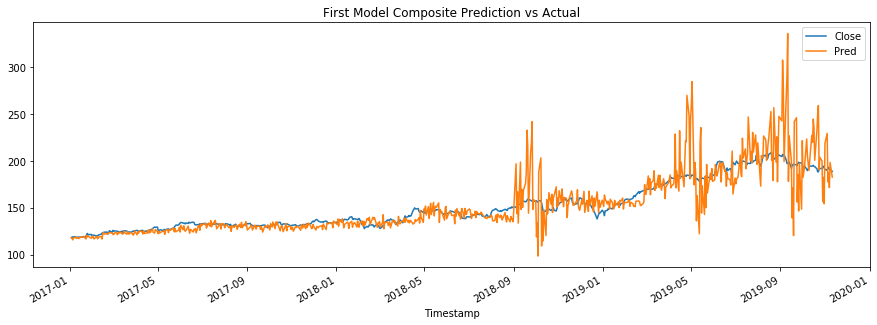

In [20]:
# Plot the first model (least training data) by sampling every 30th prediction (step) and appending to a list

first_model = []
for i in np.arange(0, len(X_test), step):
    first_model.append(pred_dict[0][i]['Pred'])

#unravel the array to plot the prediction over the actual
first_pred = np.concatenate(first_model).ravel().tolist()

#create a df with the timestamps and actual Close prices
first_results = pd.DataFrame(base_test) #base_test[step:]

#trim the length to match base_test as the last step isn't exactly 30 due to training set size
first_results = first_results[:len(first_pred)]

#add the prediction to the df
first_results['Pred'] = first_pred

#plot the df
first_results.plot(figsize=(15,5), title='First Model Composite Prediction vs Actual')

In [21]:
#Aggregate Error for the Composite Line above

first_total_MAE = metrics.mean_absolute_error(first_results['Close'], first_results['Pred'])
first_total_RMSE = metrics.mean_squared_error(first_results['Close'], first_results['Pred'])

print('Aggregate Error for the Composite Line')
print('Mean Absolute Error:',first_total_MAE)
print('Mean Squared Error:',first_total_RMSE)

Aggregate Error for the Composite Line
Mean Absolute Error: 9.539323283437094
Mean Squared Error: 324.70101197134187


In [22]:
#Pearson Correlation for First Model

first_corr = first_results.corr(method='pearson')['Close']['Pred']
print ('Pearson Correlation for Close & Prediction:',first_corr)

Pearson Correlation for Close & Prediction: 0.8520331731655829


In [23]:
#Plot the First Models Error by Prediction Horizon ie. Error at t+1 through t+30

first_error = pred_dict[0][0]

#Sample the predictions
for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[0][i])
    three = first_error.append(two, ignore_index=True)
    first_error = three

#Add the Actual Values
first_error['Actual'] = base_test.values[0:len(first_error)]

#intialize a list
first_error_by_day = list()

#calcualte the errors at each day by slicing the df
for i in range(1,31):
    df = first_error[first_error.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    first_error_by_day.append(error)

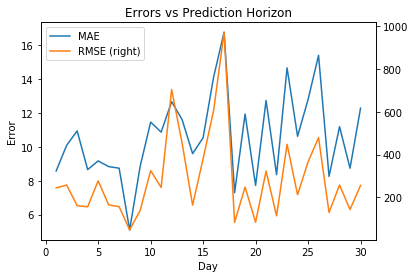

In [24]:
#Plot the Error vs Day

first_error_day = pd.DataFrame.from_records(first_error_by_day, columns=['Day', 'MAE', 'RMSE'])
first_ax = first_error_day.plot(x='Day', y=['MAE','RMSE'], 
                          secondary_y=['RMSE'],
                         title = 'Errors vs Prediction Horizon')
first_ax.set(ylabel='Error')
plt.show()

#### Last Model

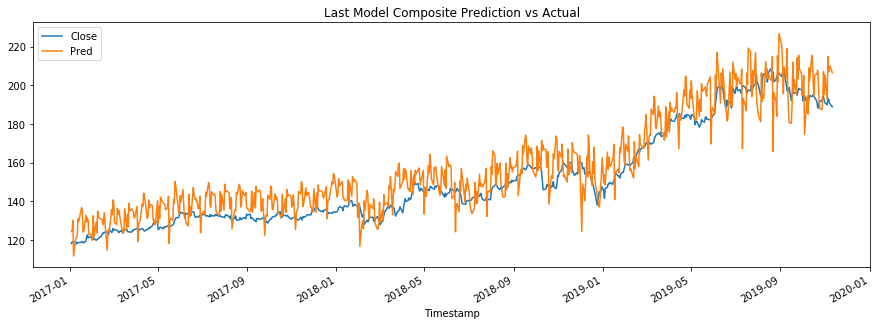

In [25]:
# Plot the last model (most training data) by sampling every 30th prediction (step) and appending to a list

last_model = []
for i in np.arange(0,len(X_test),step):
    last_model.append(pred_dict[max(pred_dict)][i]['Pred'])

#unravel the array to plot the prediction over the actual
last_pred = np.concatenate(last_model).ravel().tolist()

#create a df with the timestamps and actual Close prices
last_results = pd.DataFrame(base_test) #base_test[step:]

#trim the length to match base_test as the last step isn't exactly 30 due to training set size
last_results = last_results[:len(last_pred)]

#add the prediction to the df
last_results['Pred'] = last_pred

#plot the df
last_results.plot(figsize=(15,5), title='Last Model Composite Prediction vs Actual')

In [26]:
#Aggregate Error for the Composite Line above
last_total_MAE = metrics.mean_absolute_error(last_results['Close'], last_results['Pred'])
last_total_RMSE = metrics.mean_squared_error(last_results['Close'], last_results['Pred'])

print('Aggregate Error for the Composite Line')
print('Mean Absolute Error:',last_total_MAE)
print('Mean Squared Error:',last_total_RMSE)

Aggregate Error for the Composite Line
Mean Absolute Error: 8.603454018063015
Mean Squared Error: 109.56812269228578


In [27]:
last_corr = last_results.corr(method='pearson')['Close']['Pred']
print ('Pearson Correlation for Close & Prediction:',last_corr)

Pearson Correlation for Close & Prediction: 0.9411942629383578


In [28]:
#sample the last models predicitons to see the error by forecast day

last_error = pred_dict[max(pred_dict)][0]

#sample the predictions
for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[max(pred_dict)][i])
    three = last_error.append(two, ignore_index=True)
    last_error = three

#add in the actual values
last_error['Actual'] = base_test.values[0:len(last_error)]

#create a list
last_error_by_day = list()

#calculate the error by day
for i in range(1,31):
    df = last_error[last_error.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    last_error_by_day.append(error)

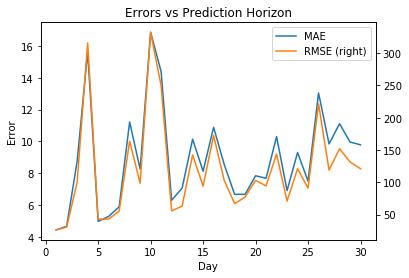

In [29]:
#Plot the Error vs Day

last_error_day = pd.DataFrame.from_records(last_error_by_day, columns=['Day', 'MAE', 'RMSE'])
last_ax = last_error_day.plot(x='Day', y=['MAE','RMSE'], 
                          secondary_y=['RMSE'],
                         title = 'Errors vs Prediction Horizon')
last_ax.set(ylabel='Error')
plt.show()